# Megaline Tariff Revenue Analysis

## Introduccion

# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [340]:
# Cargar todas las librerías
import pandas as pd
import math as mt
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


## Cargar datos

In [341]:
# Carga los archivos de datos en diferentes DataFrames

llamadas = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
mensajes = pd.read_csv('/datasets/megaline_messages.csv')
tarifas = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [342]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
print(tarifas.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [343]:
# Imprime una muestra de los datos para las tarifas
tarifas.sample(2)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Desde mi perspectiva veo que tanto "usd_per_message" como "usd_per_minute" tiene los costos erroneos, de aceurdo a la tabla de precios de los 2 planes esas 2 caisllas estan erroneas, por lo cual se necesita reemplazar con la informacion correcta.

Plan Surf si se exceden los límites del paquete el costo correcto seria:
1 minuto: 3 centavos.
1 SMS: 3 centavos.

Plan Ultimate si se exceden los límites del paquete el costo correcto seria:
1 minuto: 1 centavo.
1 SMS: 1 centavo.

Tambien quiero pasar los valores que tienen decimales a valores enteros

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [344]:
tarifas.loc[0, 'usd_per_message'] = 3
tarifas.loc[0, 'usd_per_minute'] = 3
tarifas.loc[1, 'usd_per_message'] = 1
tarifas.loc[1, 'usd_per_minute'] = 1


print(tarifas.info)

<bound method DataFrame.info of    messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10              3.0             3.0      surf  
1               70           7              1.0             1.0  ultimate  >


## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [345]:
#Pasar los valores de decimales a valores enteros
tarifas['usd_per_message'] = tarifas['usd_per_message'].astype(int)
tarifas['usd_per_minute'] = tarifas['usd_per_minute'].astype(int)


print(tarifas.info)

#Aqui converti los mb a GB y lo pase a valores enteros
tarifas['gb_per_month_included'] = (tarifas['mb_per_month_included'] / 1024).round(2).astype(int)


print(tarifas[['plan_name', 'mb_per_month_included', 'gb_per_month_included']])

<bound method DataFrame.info of    messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10                3               3      surf  
1               70           7                1               1  ultimate  >
  plan_name  mb_per_month_included  gb_per_month_included
0      surf                  15360                     15
1  ultimate                  30720                     30


## Usuarios/as

In [346]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [347]:
# Imprime una muestra de datos para usuarios
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
475,1475,Arlen,Sutton,66,"Dallas-Fort Worth-Arlington, TX MSA",2018-05-28,ultimate,NaN
273,1273,Hermila,Ryan,25,"Baton Rouge, LA MSA",2018-10-13,ultimate,NaN
484,1484,Delpha,Baldwin,46,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
263,1263,Lucio,Duffy,39,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

A groso modo lo que veo es que este dataframe en la seccion "churn_date" hay datos ausentes, por lo que se vuelve informacion que no tenemos certeza del todo, y debemos de reemplazarla por el valor "unknown" para donde tengamos NaN, ya que son valores que no podemos recolectar.

Y para la seccion 'reg_date' cambiamos el formato para que este alineado en cuanto formato con los demas dataframes.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [348]:
users['reg_date'] = pd.to_datetime(users['reg_date']).dt.strftime('%d-%m-%Y')
users['churn_date'] = pd.to_datetime(users['churn_date']).dt.strftime('%d-%m-%Y')

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [349]:
users['churn_date'] = users['churn_date'].fillna('unknown')

users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
26,1026,Meggan,Hamilton,49,"Houston-The Woodlands-Sugar Land, TX MSA",20-07-2018,ultimate,unknown
365,1365,Milford,Rush,19,"Grand Rapids-Kentwood, MI MSA",09-02-2018,surf,unknown
111,1111,Booker,Hahn,75,"Urban Honolulu, HI MSA",17-09-2018,surf,unknown
37,1037,Reena,Velazquez,20,"Seattle-Tacoma-Bellevue, WA MSA",11-08-2018,ultimate,unknown
480,1480,Jasper,Buchanan,46,"St. Louis, MO-IL MSA",13-12-2018,surf,unknown


## Llamadas

In [350]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print(llamadas.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [351]:
# Imprime una muestra de datos para las llamadas

llamadas.sample(5)

,id,user_id,call_date,duration
49522,1179_181,1179,2018-10-18,1.81
55472,1199_0,1199,2018-12-09,4.39
118052,1412_336,1412,2018-09-25,2.26
132157,1476_83,1476,2018-07-14,8.01
116757,1408_406,1408,2018-04-12,13.13


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Para este dataframe veo 3 situaciones que podemos correguir y por el otro lado enriqueser

1-Para la seccion de id como es un valor unico por llamada podemos quitarle el guion bajo ("_") para que sea mas legible 

2-Ahora para seccion duration como a la hora de ser cobrado siempre se redondea para arriba aun que se haya pasado por un segundo lo ideal es que los redondemos todos y le quitemos lo decimales, lo cual nos ayudara mas adelante para poder realizar lo calculos de la mejor manera y poder tomar una desicion mas certera.

3-Veo valioso de cambiar es el formato de la fecha ya segun detallo esta (aa-mm-dd) para lo que debemos establecer un unico formato para la fecha para que todos lo dataframes podamos tener coincidencia en la informacion cuando necesitamos buscarla por fecha.


### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [352]:
llamadas['id'] = llamadas['id'].str.replace('_', '')

llamadas['call_date'] = pd.to_datetime(llamadas['call_date']).dt.strftime('%d-%m-%Y')

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [353]:
llamadas['duration'] = np.ceil(llamadas['duration']).astype(int)

llamadas.sample(5)

,id,user_id,call_date,duration
33498,1126183,1126,30-11-2018,20
103425,1365621,1365,21-09-2018,13
85859,1316103,1316,19-11-2018,0
2077,1009499,1009,26-07-2018,5
83286,130260,1302,03-11-2018,12


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buen trabajo en redondear la duración de las llamadas.
    
</div>

## Mensajes

In [354]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

print(mensajes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [355]:
# Imprime una muestra de datos para los mensajes

mensajes.sample(5)

,id,user_id,message_date
44416,1295_49,1295,2018-10-29
9228,1067_87,1067,2018-10-22
40057,1259_80,1259,2018-11-24
71998,1467_330,1467,2018-06-03
22284,1133_272,1133,2018-11-14


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

1-veo valioso de cambiar es el formato de la fecha ya segun detallo esta (aa-mm-dd) para lo que debemos establecer un unico formato para la fecha para que todos lo dataframes podamos tener coincidencia en la informacion cuando necesitamos buscarla por fecha.

2-Se corrige en la seccion 'id' el guion bajo en medio de los numeros.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [356]:
mensajes['id'] = mensajes['id'].str.replace('_', '')

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [357]:
mensajes['message_date'] = pd.to_datetime(mensajes['message_date']).dt.strftime('%d-%m-%Y')

mensajes.sample(5)

,id,user_id,message_date
51752,1335343,1335,18-08-2018
15648,110312,1103,17-12-2018
63128,140151,1401,27-12-2018
42581,128068,1280,24-11-2018
19173,112460,1124,22-11-2018


## Internet

In [358]:
# Imprime la información general/resumida sobre el DataFrame de internet
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [359]:
#Imprime una muestra de datos para el tráfico de internet
internet.sample(5)

,id,user_id,session_date,mb_used
60845,1277_148,1277,2018-12-20,604.29
7252,1041_92,1041,2018-10-11,590.23
95735,1446_279,1446,2018-09-17,498.03
76956,1360_30,1360,2018-12-29,624.56
12179,1059_288,1059,2018-12-03,517.07


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]


1-De acuerdo a la descripcion de las tarifas para el trafico web "mb_used" si un cliente se pasa por tan solo un megabyte se redondea hacia arriba por ende tambien lo convertiremos a numeros enteros.

2-Otro punto que veo valioso de cambiar es el formato de la fecha ya segun detallo esta (aa-mm-dd) para lo que debemos establecer un unico formato (dd, mm, aa) para la fecha para que todos lo dataframes podamos tener coincidencia en la informacion cuando necesitamos buscarla por fecha.

3-Para la seccion de id como es un valor unico por llamada podemos quitarle el guion bajo ("_") para que sea mas legible 

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [360]:
internet['id'] = internet['id'].str.replace('_', '')

internet['session_date'] = pd.to_datetime(internet['session_date']).dt.strftime('%d-%m-%Y')

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [361]:
internet['mb_used'] = np.ceil(internet['mb_used']).astype(int)
internet.sample(5)

print()

internet['gb_used'] = (internet['mb_used'] / 1024).round(0).astype(int)

# Imprimir el DataFrame actualizado para verificar los cambios
print(internet[['user_id', 'session_date', 'mb_used', 'gb_used']])


        user_id session_date  mb_used  gb_used
0          1000   29-12-2018       90        0
1          1000   31-12-2018        0        0
2          1000   28-12-2018      661        1
3          1000   26-12-2018      271        0
4          1000   27-12-2018      881        1
...         ...          ...      ...      ...
104820     1499   20-10-2018      219        0
104821     1499   30-12-2018      305        0
104822     1499   22-09-2018      293        0
104823     1499   07-12-2018        0        0
104824     1499   24-12-2018      759        1

[104825 rows x 4 columns]


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buen trabajo en redondear la variable. Solamente recuerda que debemos de hacerlo una vez que hagamos la transformación de mb a gb
    
</div>

## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [362]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
for i, row in tarifas.iterrows():
    print(f"Tarifa: {row['plan_name']}")
    print(f"Pago mensual: ${row['usd_monthly_pay']}")
    print(f"Minutos incluidos al mes: {row['minutes_included']} minutos")
    print(f"SMS incluidos al mes: {row['messages_included']} SMS")
    print(f"Datos incluidos al mes: {row['mb_per_month_included'] / 1024} GB")
    print(f"Costo adicional por minuto: ${row['usd_per_minute']} centavos")
    print(f"Costo adicional por SMS: ${row['usd_per_message']} centavos")
    print(f"Costo adicional por GB: ${row['usd_per_gb']} dólares")
    print("-" * 40)


print("Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes.")
print("Cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contara como un minuto.")
print("Para el tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.")


Tarifa: surf
Pago mensual: $20
Minutos incluidos al mes: 500 minutos
SMS incluidos al mes: 50 SMS
Datos incluidos al mes: 15.0 GB
Costo adicional por minuto: $3 centavos
Costo adicional por SMS: $3 centavos
Costo adicional por GB: $10 dólares
----------------------------------------
Tarifa: ultimate
Pago mensual: $70
Minutos incluidos al mes: 3000 minutos
SMS incluidos al mes: 1000 SMS
Datos incluidos al mes: 30.0 GB
Costo adicional por minuto: $1 centavos
Costo adicional por SMS: $1 centavos
Costo adicional por GB: $7 dólares
----------------------------------------
Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes.
Cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contara como un minuto.
Para el tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [379]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
llamadas['call_date'] = pd.to_datetime(llamadas['call_date'])
llamadas['month'] = llamadas['call_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')

pivot_llamadas = llamadas.pivot_table(index=['user_id', 'month'],
                            values=['duration'],
                            aggfunc=['sum', 'count']).reset_index()

pivot_llamadas.columns = ['user_id', 'month', 'total_duration', 'call_count']


print(pivot_llamadas.sample(5))

      user_id       month  total_duration  call_count
4571     1456  28-02-2018              62           7
3822     1385  31-12-2018             480          65
789      1081  30-04-2018              74          12
1160     1120  31-12-2018             445          54
4784     1477  30-06-2018              20           3


In [364]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutos_por_mes = llamadas.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_minutos')
llamadas = llamadas.merge(minutos_por_mes, on=['user_id', 'month'], how='left')

llamadas.sample(5)

,id,user_id,call_date,duration,month,total_minutos
133283,148366,1483,2018-10-22,6,31-10-2018,345
75328,126750,1267,2018-12-19,0,31-12-2018,986
73103,1259123,1259,2018-10-30,10,31-10-2018,112
114913,1402159,1402,2018-10-23,7,31-10-2018,213
93802,133530,1335,2018-06-17,16,30-06-2018,305


In [365]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
mensajes['message_date'] = pd.to_datetime(mensajes['message_date'])
mensajes['month'] = mensajes['message_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
mensajes_por_mes = mensajes.groupby(['user_id', 'month']).size().reset_index(name='num_mensajes')
mensajes = mensajes.drop(columns=['num_mensajes'], errors='ignore')
mensajes = mensajes.merge(mensajes_por_mes, on=['user_id', 'month'], how='left')

mensajes.sample(5)

,id,user_id,message_date,month,num_mensajes
3224,103659,1036,2018-06-25,30-06-2018,38
24454,1145309,1145,2018-07-08,31-07-2018,61
41560,126771,1267,2018-11-29,30-11-2018,18
5021,104683,1046,2018-06-30,30-06-2018,26
56065,135531,1355,2018-11-10,30-11-2018,62


In [366]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['month'] = internet['session_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
datos_por_mes = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index(name='total_gb_usado')
internet = internet.drop(columns=['num_mb_used'], errors='ignore')
internet = internet.merge(datos_por_mes, on=['user_id', 'month'], how='left')

internet.sample(5)

,id,user_id,session_date,mb_used,gb_used,month,total_gb_usado
70702,133087,1330,2018-11-16,0,0,30-11-2018,5
16879,1076495,1076,2018-03-12,523,1,31-03-2018,4
41130,1185167,1185,2018-04-25,73,0,30-04-2018,22
15374,1069357,1069,2018-11-14,830,1,30-11-2018,7
22833,11066,1106,2018-12-23,419,0,31-12-2018,18


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [367]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

llamadas['call_date'] = pd.to_datetime(llamadas['call_date'])
mensajes['message_date'] = pd.to_datetime(mensajes['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

llamadas['month'] = llamadas['call_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
mensajes['month'] = mensajes['message_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
internet['month'] = internet['session_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')

llamadas_por_mes = llamadas.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_minutos')
mensajes_por_mes = mensajes.groupby(['user_id', 'month']).size().reset_index(name='num_mensajes')
datos_por_mes = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index(name='total_gb_usado')

datos_agregados = pd.merge(llamadas_por_mes, mensajes_por_mes, on=['user_id', 'month'], how='outer')
datos_agregados = pd.merge(datos_agregados, datos_por_mes, on=['user_id', 'month'], how='outer')


datos_agregados.sample(5)


,user_id,month,total_minutos,num_mensajes,total_gb_usado
1343,1142,30-09-2018,372.0,22.0,8.0
5127,1315,30-04-2018,NaN,1.0,NaN
161,1018,31-05-2018,86.0,1.0,0.0
2821,1288,31-01-2018,15.0,NaN,0.0
4747,1474,30-04-2018,39.0,5.0,1.0


In [368]:
# Añade la información de la tarifa
limites = {
    'Surf': {'minutos': 500, 'mensajes': 50, 'datos': 15},
    'Ultimate': {'minutos': 3000, 'mensajes': 1000, 'datos': 30}
}

[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [369]:
# Calcula el ingreso mensual para cada usuario

llamadas['call_date'] = pd.to_datetime(llamadas['call_date'])
mensajes['message_date'] = pd.to_datetime(mensajes['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])


llamadas['month'] = llamadas['call_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
mensajes['month'] = mensajes['message_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')
internet['month'] = internet['session_date'].dt.to_period('M').dt.strftime('%d-%m-%Y')


llamadas_por_mes = llamadas.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_minutos')
mensajes_por_mes = mensajes.groupby(['user_id', 'month']).size().reset_index(name='num_mensajes')
datos_por_mes = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index(name='total_gb_usado')


datos_agregados = pd.merge(llamadas_por_mes, mensajes_por_mes, on=['user_id', 'month'], how='outer')
datos_agregados = pd.merge(datos_agregados, datos_por_mes, on=['user_id', 'month'], how='outer')


datos_agregados = datos_agregados.fillna(0)


datos_agregados = pd.merge(datos_agregados, users[['user_id', 'plan', 'city']], on='user_id', how='left')

datos_agregados = pd.merge(datos_agregados, tarifas, left_on='plan', right_on='plan_name', how='left')


datos_agregados['plan'] = datos_agregados['plan'].str.lower()


limites = {
    'surf': {'minutos': 500, 'mensajes': 50, 'datos': 15},
    'ultimate': {'minutos': 3000, 'mensajes': 1000, 'datos': 30}
}


def calcular_cargos(row):
    plan = row['plan']
    cargos_minutos = max(0, row['total_minutos'] - limites[plan]['minutos']) * row['usd_per_minute']
    cargos_mensajes = max(0, row['num_mensajes'] - limites[plan]['mensajes']) * row['usd_per_message']
    cargos_datos = max(0, row['total_gb_usado'] - limites[plan]['datos']) * row['usd_per_gb']
    return cargos_minutos + cargos_mensajes + cargos_datos


datos_agregados['cargos_adicionales'] = datos_agregados.apply(calcular_cargos, axis=1)


datos_agregados['ingreso_mensual'] = datos_agregados['usd_monthly_pay'] + datos_agregados['cargos_adicionales']


datos_agregados.sample(5)

,user_id,month,total_minutos,num_mensajes,total_gb_usado,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,cargos_adicionales,ingreso_mensual
2330,1240,30-09-2018,817.0,7.0,25.0,surf,"Baton Rouge, LA MSA",50,15360,500,20,10,3,3,surf,15,1051.0,1071.0
4335,1433,31-12-2018,580.0,91.0,16.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",1000,30720,3000,70,7,1,1,ultimate,30,0.0,70.0
1484,1155,28-02-2018,185.0,19.0,11.0,ultimate,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",1000,30720,3000,70,7,1,1,ultimate,30,0.0,70.0
3429,1348,31-05-2018,76.0,7.0,1.0,surf,"Detroit-Warren-Dearborn, MI MSA",50,15360,500,20,10,3,3,surf,15,0.0,20.0
242,1028,31-07-2018,41.0,77.0,39.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",1000,30720,3000,70,7,1,1,ultimate,30,63.0,133.0


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

        plan       month  total_minutos
9       surf  31-08-2018     211.123333
17  ultimate  31-01-2018      71.631579
7       surf  31-05-2018     136.903780
5       surf  31-01-2018      71.031469
6       surf  31-03-2018      88.127586


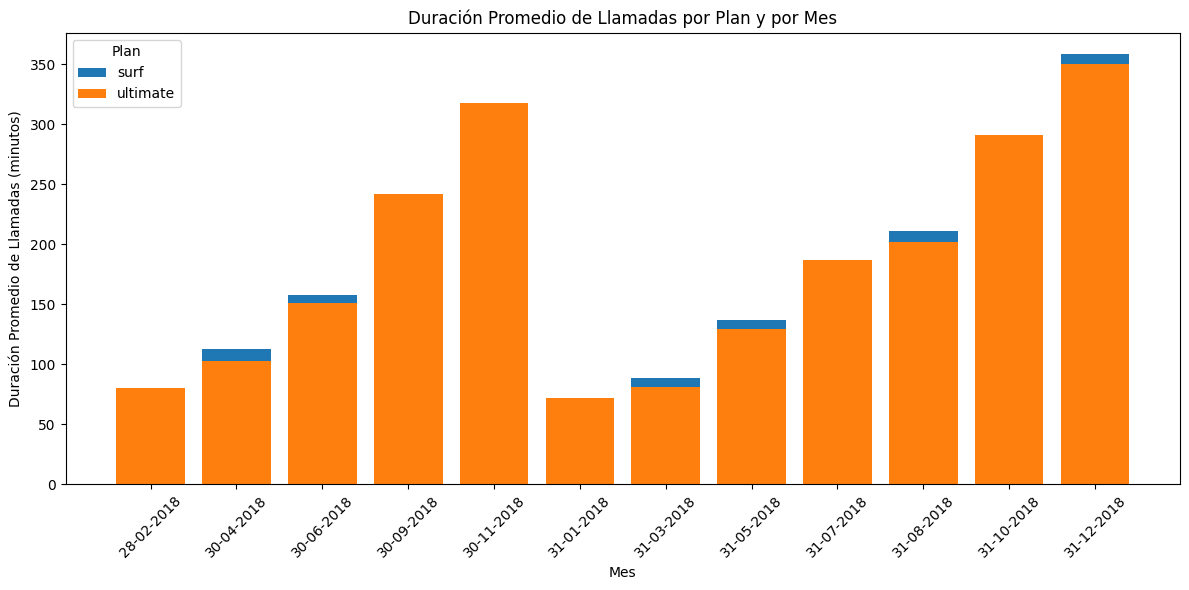

In [370]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

duracion_promedio_llamadas = datos_agregados.groupby(['plan', 'month'])['total_minutos'].mean().reset_index()
print(duracion_promedio_llamadas.sample(5))

plt.figure(figsize=(12, 6))
for plan in duracion_promedio_llamadas['plan'].unique():
    subset = duracion_promedio_llamadas[duracion_promedio_llamadas['plan'] == plan]
    plt.bar(subset['month'].astype(str), subset['total_minutos'], label=plan)

plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas (minutos)')
plt.title('Duración Promedio de Llamadas por Plan y por Mes')
plt.legend(title='Plan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

          plan  total_minutos
1078  ultimate          695.0
3828      surf           12.0
1901      surf           71.0
3206      surf          408.0
3210      surf          735.0


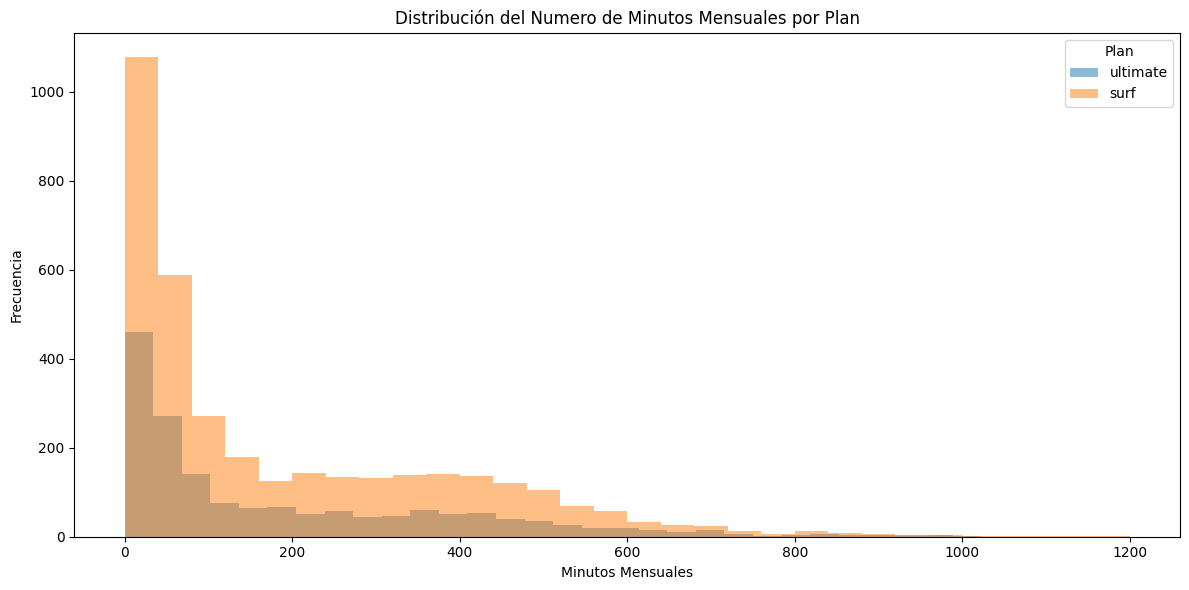

In [371]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

minutos_mensuales_por_plan = datos_agregados[['plan', 'total_minutos']]

print(minutos_mensuales_por_plan.sample(5))


plt.figure(figsize=(12, 6))

for plan in minutos_mensuales_por_plan['plan'].unique():
    subset = minutos_mensuales_por_plan[minutos_mensuales_por_plan['plan'] == plan]
    plt.hist(subset['total_minutos'], bins=30, alpha=0.5, label=plan)

plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución del Numero de Minutos Mensuales por Plan')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [372]:
# Calcula la media y la varianza de la duración mensual de llamadas.
estadisticas_llamadas = datos_agregados.groupby('plan')['total_minutos'].agg(['mean', 'var']).reset_index()

print(estadisticas_llamadas)


       plan        mean           var
0      surf  189.125911  41029.486246
1  ultimate  186.588802  41407.667561


          plan  total_minutos
5087      surf            0.0
598   ultimate          302.0
2796      surf          290.0
4420  ultimate           56.0
4588  ultimate           13.0


<Figure size 1000x600 with 0 Axes>

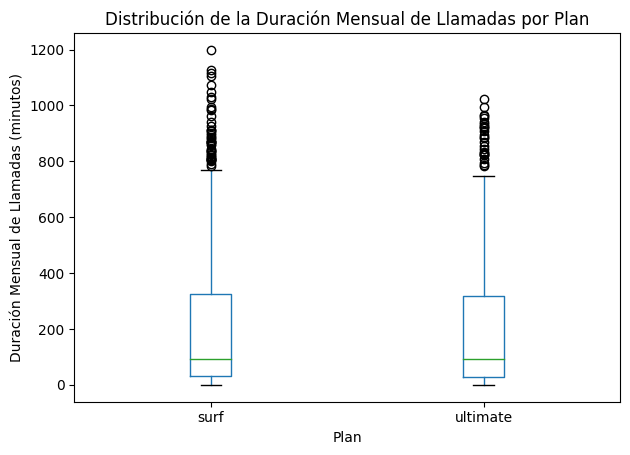

In [373]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
llamadas_por_plan = datos_agregados[['plan', 'total_minutos']]

print(llamadas_por_plan.sample(5))

plt.figure(figsize=(10, 6))
llamadas_por_plan.boxplot(column='total_minutos', by='plan', grid=False)


plt.xlabel('Plan')
plt.ylabel('Duración Mensual de Llamadas (minutos)')
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.suptitle('')  
plt.tight_layout()
plt.show()


[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

Desde mi perspectiva los datas me dicen que el comportamiento de los usuarios con respecto a las llamadas no tiene una cambio significativo en funcion del plan que tiene cada uno, ya que tanto la duracion promedio como la varianza de las llamadas son muy similares entre los dos planes. La alta variabilidad me dice que otros factores que van mas alla del tipo de plan, podrian estar influyendo en la duracion de las llamadas de los usuarios como tal.

### Mensajes

        plan       month       mean         var
4       surf  30-11-2018  23.680921  602.310394
21  ultimate  31-08-2018  17.919708  618.515565
14  ultimate  30-06-2018  12.735294  406.536819
0       surf  28-02-2018   5.100346   54.173923
1       surf  30-04-2018   7.051724  164.381398


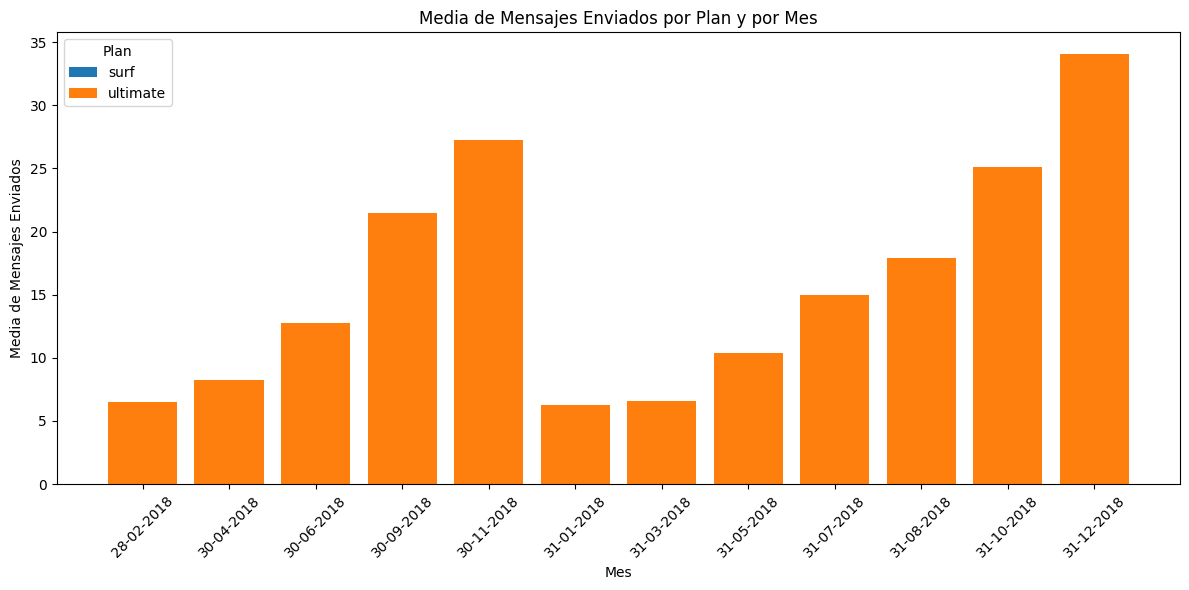

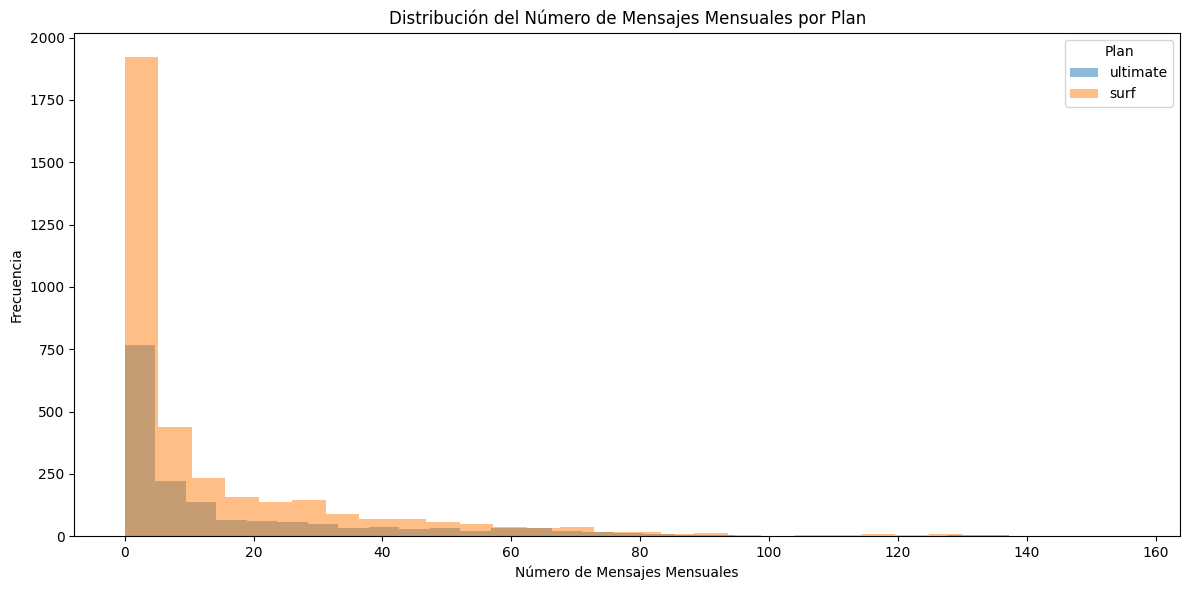

In [374]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

estadisticas_mensajes = datos_agregados.groupby(['plan', 'month'])['num_mensajes'].agg(['mean', 'var']).reset_index()

print(estadisticas_mensajes.sample(5))

plt.figure(figsize=(12, 6))
for plan in estadisticas_mensajes['plan'].unique():
    subset = estadisticas_mensajes[estadisticas_mensajes['plan'] == plan]
    plt.bar(subset['month'].astype(str), subset['mean'], label=plan)

plt.xlabel('Mes')
plt.ylabel('Media de Mensajes Enviados')
plt.title('Media de Mensajes Enviados por Plan y por Mes')
plt.legend(title='Plan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for plan in datos_agregados['plan'].unique():
    subset = datos_agregados[datos_agregados['plan'] == plan]
    plt.hist(subset['num_mensajes'], bins=30, alpha=0.5, label=plan)

plt.xlabel('Número de Mensajes Mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución del Número de Mensajes Mensuales por Plan')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

        plan       month      mean        var
20  ultimate  31-07-2018  5.977941  53.843954
3       surf  30-09-2018  7.510067  48.890471
18  ultimate  31-03-2018  2.948529  26.493627
4       surf  30-11-2018  9.779605  41.980969
2       surf  30-06-2018  4.627986  35.830310


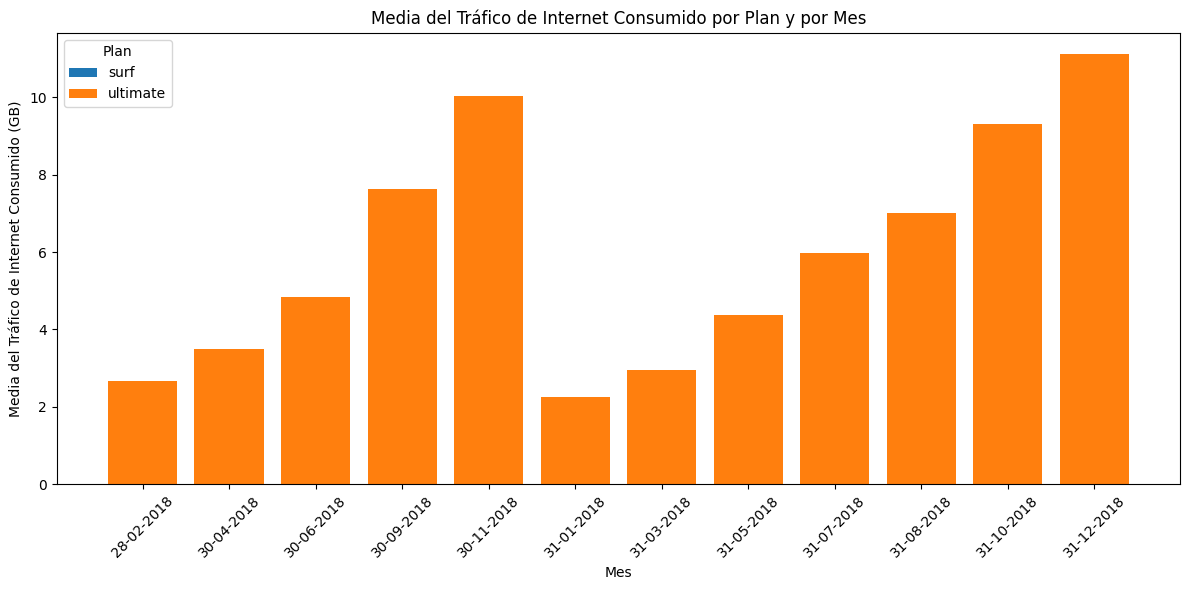

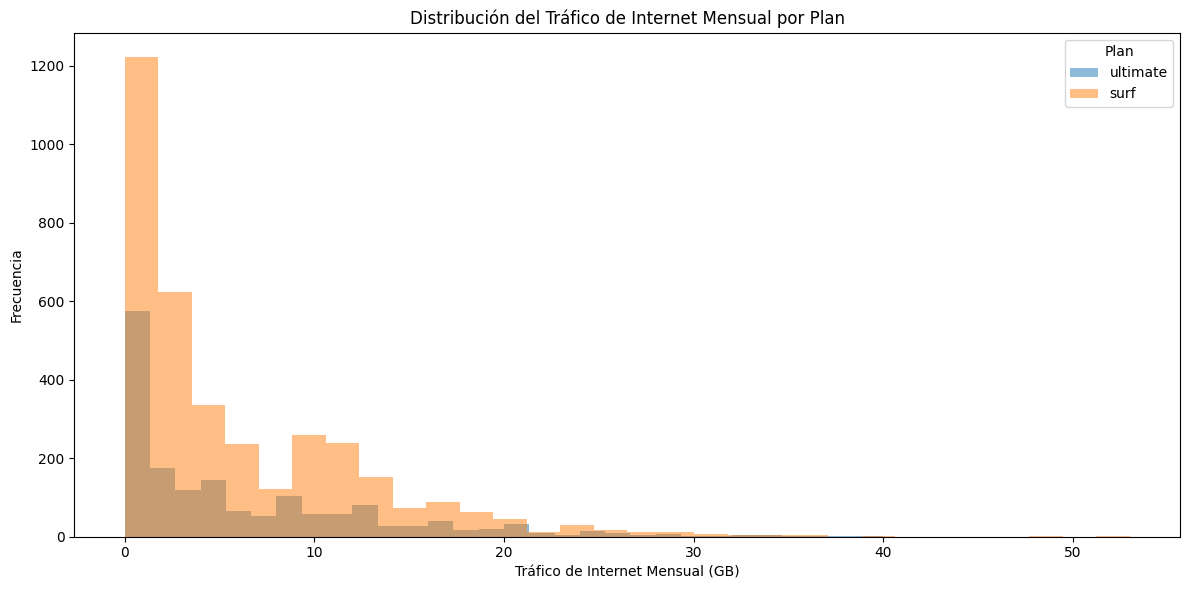

In [375]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
estadisticas_internet = datos_agregados.groupby(['plan', 'month'])['total_gb_usado'].agg(['mean', 'var']).reset_index()


print(estadisticas_internet.sample(5))

plt.figure(figsize=(12, 6))
for plan in estadisticas_internet['plan'].unique():
    subset = estadisticas_internet[estadisticas_internet['plan'] == plan]
    plt.bar(subset['month'].astype(str), subset['mean'], label=plan)

plt.xlabel('Mes')
plt.ylabel('Media del Tráfico de Internet Consumido (GB)')
plt.title('Media del Tráfico de Internet Consumido por Plan y por Mes')
plt.legend(title='Plan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()    

print()
plt.figure(figsize=(12, 6))

for plan in datos_agregados['plan'].unique():
    subset = datos_agregados[datos_agregados['plan'] == plan]
    plt.hist(subset['total_gb_usado'], bins=30, alpha=0.5, label=plan)

plt.xlabel('Tráfico de Internet Mensual (GB)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tráfico de Internet Mensual por Plan')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

Ahora bien, puedo decir que si, el comportamiento de los usuarios con respecto a los mensajes varía en función del plan, ya que los usuarios del plan Surf muestran una mayor tendencia a enviar mas mensajes y presentan una mayor variabilidad en su comportamiento con respecto a los mensajes enviados, pero si vemos en comparacion con los usuarios del plan Ultimate que son los que tienden a enviar menos mensajes de manera mas consistente.Ahora bien, puedo decir que los usuarios del plan Surf muestran una mayor tendencia a enviar mas mensajes y presentan una mayor variabilidad en su comportamiento con respecto a los mensajes enviados, pero si vemos en comparacion con los usuarios del plan Ultimate que son los que tienden a enviar menos mensajes de manera mas consistente.

### Internet

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

Puedo decir que si, que dicho compartamiento de los usuarios con respecto al consumo de trafico de internet cambia en funcion del plan que tengan, ya que los usuarios del plan Ultimate tienen una tendencia a consumir mas trafico de internet en promedio, y ambos planes muestran una alta variabilidad en el consumo de datos por lo cual esto nos dice que los usuarios tienen comportamientos muy diferentes en terminos de consumo de internet, lo cual puede estar influenciado por las diferentes caracteristicas y beneficios ofrecidos por cada plan.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [376]:
ingreso_total_por_plan = datos_agregados.groupby('plan')['ingreso_mensual'].sum().reset_index()

# Imprimir los ingresos totales por plan
print(ingreso_total_por_plan)

print()


estadisticas_ingresos = datos_agregados.groupby('plan')['ingreso_mensual'].agg(['mean', 'var', 'min', 'max', 'median', 'count']).reset_index()
percentiles = datos_agregados.groupby('plan')['ingreso_mensual'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
estadisticas_completas = pd.merge(estadisticas_ingresos, percentiles, on='plan', suffixes=('', '_percentile'))
estadisticas_completas.rename(columns={0.25: '25%', 0.5: '50%', 0.75: '75%'}, inplace=True)

print(estadisticas_completas)

       plan  ingreso_mensual
0      surf         237015.0
1  ultimate         116802.0

       plan       mean           var   min     max  median  count   25%   50%  \
0      surf  66.465227  33476.927122  20.0  2347.0    20.0   3566  20.0  20.0   
1  ultimate  70.320289     13.652775  70.0   140.0    70.0   1661  70.0  70.0   

    75%  
0  20.0  
1  70.0  


[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

El ingreso entre ambos planes tiene una diferencia significativamente, ya que el plan Surf se vuelve mas resntable si hablamos de ingresos totakes como tal, ahora bien, por el otro lado el plan Ultimate tiende a generar mas ingresos de forma consitente por usuario pero vemos que lo ingresos son menos que los del plan Surf, por lo que dichos resultados nos dice que el plan Surf viene a ser mas rentable por lo general si de ingresos hablamos pero el plan Ultimate nos da ingresos predecibles que no da un respaldo a nivel de organizacion como tal.

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [377]:
# Prueba las hipótesis
ingresos_ultimate = datos_agregados[datos_agregados['plan'] == 'ultimate']['ingreso_mensual']
ingresos_surf = datos_agregados[datos_agregados['plan'] == 'surf']['ingreso_mensual']


t_stat, p_value = ttest_ind(ingresos_ultimate, ingresos_surf, equal_var=False)


print(f"Estadistico t: {t_stat}")
print(f"Valor p: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipotesis nula: Los ingresos promedio son diferentes entre los planes Ultimate y Surf.")
else:
    print("No podemos rechazar la hipotesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre los planes Ultimate y Surf.")

Estadistico t: 1.2576482244274017
Valor p: 0.20860123514825077
No podemos rechazar la hipotesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre los planes Ultimate y Surf.


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [378]:
# Prueba las hipótesis
ny_nj_cities = ['New York-Newark-Jersey City, NY-NJ-PA MSA']

ingresos_ny_nj = datos_agregados[datos_agregados['city'].isin(ny_nj_cities)]['ingreso_mensual']
ingresos_otras_regiones = datos_agregados[~datos_agregados['city'].isin(ny_nj_cities)]['ingreso_mensual']

t_stat, p_value = ttest_ind(ingresos_ny_nj, ingresos_otras_regiones, equal_var=False)

print(f"Estadistico t: {t_stat}")
print(f"Valor p: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipotesis nula: Los ingresos promedio son diferentes entre el area NY-NJ y otras regiones.")
else:
    print("No podemos rechazar la hipotesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre el area NY-NJ y otras regiones.")



Estadistico t: -2.3365426533711586
Valor p: 0.019594753211933283
Rechazamos la hipotesis nula: Los ingresos promedio son diferentes entre el area NY-NJ y otras regiones.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

Conclusion General

Para las decisiones  y suposiciones importantes se realizaron varios pasos como la union de datos, calculo de ingresos mensuales, estadisticas descriptivas y pruebas de hipotesis, con o que obtuve un conjunto de informacion completa, la cual se utilizo para calcular los ingresos mensuales por usuario como tal teniendo en consideracion cargos adicionales que con el conjunto de datos nos permitio realizar un analisis del comportamiento de los usuarios y la rentabilidad de los planes.

Desde mi perspectiva los puntos claves fueron los siguientes:

1-Llamadas: ya que no hay diferencia significativa en la duracion promedio entre los planes (Surf y Ultimate), los dos planes nos muestran una alta variabilidad en cuanto duracion hablamos.

2-Mensajes: notamos que los usuarios del plan Surf envian mas mensajes en promedio y presentan mayor variabiliada en el numero de mensajes enviados como tal.

3-Internet: los usuarios del plan Ultimate consumen mas internet los que nos dice que hay y una gran diferencia de consumo los que no lleva a la consuclusion la relevante diferencia de enconsumo entre ambos planes.

4-Ingresos: como habia comentado anteriormente el pla Surf nos da mas ingresos totales siendo el pkan con ingresos mas altos, pero tiene una variabilidad mayor, pero el plan Ultimate no da una estabilidad y confianza de ingresos.

5-Pruebas de hipotesis: logamos confirmar que una diferencia realmente significativa en los ingresos entre los planes, pero no entre las ciudades de NY, NJ y otras ciudades.

Con toda la informacion recolectada y analizada nos da una vision bastante general del comportamiento de los usuarios y la rentabilidad de los planes, que nos puede llevar a la toma de decisiones de forma estretegica sobre las taridas y el enfoque le podriamos dar al servicio para incrementar lo ingresos, ya que nos dimos que nuestro plan Surf fue el mas rentable, y sabemos que los ingresos no son tan predecibles como quisieramos pero tenemos el plan Ultimate nos da la estabiliadad gracias al comportamiento de nuestro usuarios a nivel general dandonos ingresos mas estables.